## FUNCTIONS

In [13]:
import numpy as np, subprocess, itertools
import matplotlib.pyplot as plt
import timeit
###################   global parameters   ############################
# TODO: modify these parameters accordingly since I just put random values for now
R_channel = 0.7
L_channel = 5
charge_hydrogen = +0.4
charge_oxygen = -0.8
bond_length_water = 0.1
bond_angle_water = 1.88496
I_water = 1        # moment of inertia of water molecule
mass_water = 1
k_electric = 10    # electric constant, equal to (1 / (4 \pi \epsilon_0))
n_neural_particles = 10  # number of neural particles on each side
epsilon_LJ = 2.5; sigma_LJ = 0.3  # they should be different for different particles
random_force_strength = 2.0
const_force = 2.0  # constant force that drives water molecule towards the right

#######################################################################
# these are helper global variables
horizontal_coords_particles = np.linspace(0, L_channel, n_neural_particles + 2)

coords_particles = np.array(list(zip(horizontal_coords_particles, np.zeros(n_neural_particles + 2))) \
                 + list(zip(horizontal_coords_particles, R_channel * np.ones(n_neural_particles + 2))))

coords_negative_particles = np.array([
    [0,0], [L_channel, 0], [0, R_channel], [L_channel, R_channel]
])

sigma_6 = sigma_LJ ** 6
sigma_12 = sigma_LJ ** 12
mass_vector = np.array([mass_water, mass_water, I_water])
#######################################################################

def init_config():
    # generate random (x,y,theta, v_x, v_y, omega)
    temp_x = np.random.uniform(low=0.0 * L_channel, high=0.1 * L_channel) #I made it closer to the center
    
    temp_y = np.random.uniform(low=0.4 * R_channel, high=0.6 * R_channel) #I made it closer to the center
    
    temp_theta = np.random.uniform(high= 2 * np.pi)
    
    v_x, v_y, omega = np.random.normal(scale=1.0, size=3)
    
    return np.array([temp_x, temp_y, temp_theta]), np.array([v_x, v_y, omega])

def VerletNextR(r_t,v_t,a_t,h):
    r_t_plus_h = r_t + v_t*h + 0.5*a_t*h*h
    return r_t_plus_h

def VerletNextV(v_t,a_t,a_t_plus_h,h):
    v_t_plus_h = v_t + 0.5*(a_t + a_t_plus_h)*h
    return v_t_plus_h

def get_net_force_for_a_single_particle(coord, charge):
    # TODO: 1. add random force, 2. add constant fixed force pointing to the right
    # LJ forces
    displacement_vectors = coord - coords_particles
    
    distances = np.linalg.norm(displacement_vectors, axis=1)
    
    #print (np.max(distances), np.min(distances))
    
    temp_LJ_Force = epsilon_LJ * np.sum(
        np.dot(np.diag(48 * sigma_12 / np.power(distances, 14) - 24 * sigma_6 / np.power(distances, 8)),
            displacement_vectors),
        axis=0)
    # electric forces
    
    displacement_vectors_electric = coord - coords_negative_particles
    
    distances_electric = np.linalg.norm(displacement_vectors_electric, axis=1)
    
    assert (len(distances_electric) == 4)
    
    temp_electric_Force = k_electric * np.sum(
        np.dot(np.diag(charge / np.power(distances_electric, 3)),
            displacement_vectors_electric), 
        axis=0)
    
    # print charge, temp_LJ_Force, temp_electric_Force
    return temp_LJ_Force + temp_electric_Force + random_force_strength * np.random.normal(size=2) + np.array([const_force, 0]) \
            + np.array([1000000, 0]) * charge


def get_force_and_torque(d_water, r_water, theta_water):  # params: x, y, theta (define configurations)
    relative_coords_hydrogen_oxygen = np.array([
        [np.cos(theta_water + bond_angle_water / 2.0), np.sin(theta_water + bond_angle_water / 2.0)],
        [np.cos(theta_water - bond_angle_water / 2.0), np.sin(theta_water - bond_angle_water / 2.0)],
        [0, 0]
    ])
    
    coords_hydrogen_oxygen = np.array([d_water, r_water]) + bond_length_water * relative_coords_hydrogen_oxygen
    
    charge_hydrogen_oxygen = [charge_hydrogen, charge_hydrogen, charge_oxygen]
    
    temp_forces = [get_net_force_for_a_single_particle(item[0], item[1]) 
                       for item in zip(coords_hydrogen_oxygen, charge_hydrogen_oxygen)]
    
    net_force = np.sum(temp_forces, axis=0)
    
    net_torque = np.dot(np.array([temp_forces[0][1], -temp_forces[0][0]]), relative_coords_hydrogen_oxygen[0]) \
        + np.dot(np.array([temp_forces[1][1], -temp_forces[1][0]]), relative_coords_hydrogen_oxygen[1])  # assume center of mass is at Oxygen
    
    net_torque *= bond_length_water
    
    return np.array([net_force[0], net_force[1], net_torque])

def simulate(num_steps, h_stepsize=0.001):

    starttime = timeit.default_timer() # timer
    configs, velocities = init_config()
    # if not starting_config[0] is None: configs = starting_config
    configs_list, velocities_list = [], []
    for item in range(num_steps):
        configs_list.append(configs.copy())
        velocities_list.append(velocities.copy())
        temp_acceleration = get_force_and_torque(configs[0], configs[1], configs[2]) / mass_vector
        temp_next_configs = VerletNextR(configs, velocities, temp_acceleration, h_stepsize)
        temp_next_acceleration = get_force_and_torque(
            temp_next_configs[0], temp_next_configs[1], temp_next_configs[2]) / mass_vector

        temp_next_v = VerletNextV(velocities, temp_acceleration, temp_next_acceleration, h_stepsize)

        if 0 < temp_next_configs[0] < L_channel and 0 < temp_next_configs[1] < R_channel:
            configs, velocities = temp_next_configs, temp_next_v
        else:  # restart when it goes out of the channel
            configs, velocities = init_config()

    endtime = timeit.default_timer() # timer
    processtime = endtime - starttime # timer

    return np.array(configs_list), np.array(velocities_list), processtime

def getNewPos(Pos,nbins,steps=1000):
    Pos = list(zip(*Pos)) #make it a list
    hist_matrix, edges = np.histogramdd(Pos, bins= nbins,normed=0) #hist 3D
    maxnumber = hist_matrix.max()+1
    newhist_matrix = np.copy(hist_matrix)
    newhist_matrix -= maxnumber
    newhist_matrix = -newhist_matrix
    summn = newhist_matrix.sum()
    prob = newhist_matrix
    prob = prob/prob.sum() # normalized
    #building prob as n_i/all_n
    edges = np.array(edges)
    x_edge = edges[0][2]-edges[0][1]
    y_edge = edges[1][2]-edges[1][1]
    theta_edge = edges[2][2]-edges[2][1]
    
    nowPos = [Pos[0][len(Pos)],Pos[1][len(Pos)],Pos[2][len(Pos)]]
    nowX = int(nowPos[0]/x_edge)
    nowY = int(nowPos[1]/y_edge)
    nowTheta = int(nowPos[2]/theta_edge)
    
    for i in range(steps):
        # metropolis scan with prob[x][y][theta] as acceptance rate
        # numbers need to be altered, to see how many "jumps" we need during the simulation
        x = np.random.randint(0,nbins)
        y = np.random.randint(0,nbins)
        theta = np.random.randint(0,nbins)
        newPos_x = edges[0][x]+0.5*x_edge
        newPos_y = edges[1][y]+0.5*y_edge
        newPos_theta = edges[2][theta]+0.5*theta_edge
        
        newPos = np.array([newPos_x,newPos_y,newPos_theta])

        if min(1,(prob[x][y][theta]/prob[nowX][nowY][nowTheta])) > np.random.uniform():
            if newPos[0] <= 0:
                newPos[0] += 0.5*x_edge
            if newPos[0] >= 5:
                newPos[0] -= 0.5*x_edge
            if newPos[1] <= 0:
                newPos[1] += 0.5*y_edge
            if newPos[1] >= 0:
                newPos[1] -= 0.5*y_edge
            return newPos
        if i == steps-1:
            return nowPos
        
def simulate2(num_steps, h_stepsize=0.001):
    
    starttime = timeit.default_timer() # timer
    
    configs, velocities = init_config()
    
    configs_list, velocities_list = [], []
    
    for item in range(num_steps):
        configs_list.append(configs)
        
        velocities_list.append(velocities)
        
        temp_acceleration = get_force_and_torque(configs[0], configs[1], configs[2]) / mass_vector
        
        temp_next_configs = VerletNextR(configs, velocities, temp_acceleration, h_stepsize)
        
        temp_next_acceleration = get_force_and_torque(
            temp_next_configs[0], temp_next_configs[1], temp_next_configs[2]) / mass_vector
        
        temp_next_v = VerletNextV(velocities, temp_acceleration, temp_next_acceleration, h_stepsize)
        
        if 0 < temp_next_configs[0] < L_channel and 0 < temp_next_configs[1] < R_channel:
            configs, velocities = temp_next_configs, temp_next_v
        else:  # restart when it goes out of the channel
            configs, velocities = init_config()
            
        if item > 100 and item%1000 == 0:
            configs = getNewPos(configs_list,10)
            
    endtime = timeit.default_timer() # timer
    processtime = endtime - starttime # timer
    
    return np.array(configs_list), np.array(velocities_list), processtime

def visual(coords_negative_particles,coords_particles,my_positions,my_velocities,dpivalue = 100):
    """
    coords_particles denotes coordinates of the particles and charges of the membrane
    my_positions is a np.array. The shape is N*3. N denotes the simulation step.
    my_velocities is a np.array. The shape is N*3. N denotes the simulation step.
    dpivalue is the default dpi for all the figures. Reduce it to shrink all the figures
    """
    step = len(my_positions)
    fig1 = plt.figure(dpi = dpivalue)
    #draw particles and charges of the membrane
    plt.scatter(coords_particles[:,0], coords_particles[:,1])
    plt.scatter(coords_negative_particles[:,0], coords_negative_particles[:,1],s=30,c='r',marker='X')
    #draw the water's positions
    plt.scatter(my_positions[:,0], my_positions[:,1],s=10)
    #draw the water's velocity vector
    #plt.quiver(my_positions[:,0], my_positions[:,1],my_velocities[:,0], my_velocities[:,1],alpha=.5)
    #annotate the first time step
    plt.annotate('1',[my_positions[0,0],my_positions[0,1]])
    plt.scatter(my_positions[0,0],my_positions[0,1],s=50,c='g')
    #annotate the last time step
    plt.annotate(str(step),[my_positions[-1,0],my_positions[-1,1]])
    plt.scatter(my_positions[-1,0],my_positions[-1,1],s=50,c='g')
    plt.xlabel(r'$X$')
    plt.ylabel(r'$Y$')

    fig2 = plt.figure(dpi = dpivalue)
    #draw histodiagrams
    plt.subplot(231)
    plt.hist(my_positions[:,0], 20, weights=1.0/step*np.ones(shape=(step,1)), alpha=0.5)
    plt.xlabel(r'$X$')
    plt.ylabel(r'$Probability$')
    plt.subplot(232)
    plt.hist(my_positions[:,1], 20, weights=1.0/step*np.ones(shape=(step,1)), alpha=0.5)
#    print('nnnnnnn',n)
    plt.xlabel(r'$Y$')
    plt.ylabel(r'$Probability$')
    plt.subplot(233)
    plt.hist(np.cos(my_positions[:,2]), 20, weights=1.0/step*np.ones(shape=(step,1)), alpha=0.5)
#    print('nnnnnnn',n)
    plt.xlabel(r'$cos(\theta)$')
    plt.ylabel(r'$Probability$')
    plt.subplot(234)
    plt.hist(my_velocities[:,0], 20, weights=1.0/step*np.ones(shape=(step,1)), alpha=0.5)
    plt.xlabel(r'$u$')
    plt.ylabel(r'$Probability$')
    plt.subplot(235)
    plt.hist(my_velocities[:,1], 20, weights=1.0/step*np.ones(shape=(step,1)), alpha=0.5)
#    print('nnnnnnn',n)
    plt.xlabel(r'$v$')
    plt.ylabel(r'$Probability$')
    plt.subplot(236)
    plt.hist(my_velocities[:,2], 20, weights=1.0/step*np.ones(shape=(step,1)), alpha=0.5)
#    print('nnnnnnn',n)
    plt.xlabel(r'$\omega$')
    plt.ylabel(r'$Probability$')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.4,
                    wspace=0.7)

    fig3 = plt.figure(dpi = dpivalue)
    #draw trace
    plt.subplot(121)
    plt.plot(my_positions[:,0], alpha=0.5)
    plt.xlabel(r'$step$')
    plt.ylabel(r'$X$')
    plt.subplot(122)
    plt.plot(my_positions[:,1], alpha=0.5)
    plt.xlabel(r'$step$')
    plt.ylabel(r'$Y$')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.3,
                    wspace=0.3)
    
    fig4 = plt.figure(dpi = dpivalue)
    #draw particles and charges of the membrane
    #draw the water's positions
    plt.scatter(my_positions[:,1], np.cos(my_positions[:,2]),s=10)
    #draw the water's velocity vector
    #plt.quiver(my_positions[:,0], my_positions[:,1],my_velocities[:,0], my_velocities[:,1],alpha=.5)
    #annotate the first time step
    plt.annotate('1',[my_positions[0,1],np.cos(my_positions[0,2])])
    plt.scatter(my_positions[0,1],np.cos(my_positions[0,2]),s=50,c='g')
    #annotate the last time step
    plt.annotate(str(step),[my_positions[-1,1],np.cos(my_positions[-1,2])])
    plt.scatter(my_positions[-1,1],np.cos(my_positions[-1,2]),s=50,c='g')
    plt.xlabel(r'$Y$')
    plt.ylabel(r'$cos(\theta)$')
    plt.show()
    return 0


## Conventional MD

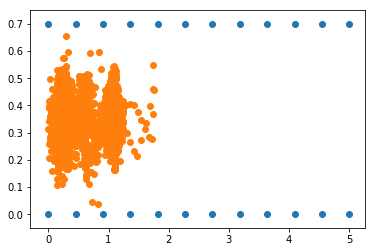

24.006109495996498 sec


In [8]:
my_positions, my_velocities, my_processtime = simulate(50000)
plt.figure(1)
plt.scatter(coords_particles[:,0], coords_particles[:,1])
#plt.scatter(coords_negative_particles[:,0], coords_negative_particles[:,1])
plt.scatter(my_positions[:,0], my_positions[:,1])
plt.show()
print (my_processtime,"sec")

## Conbination MD/MC

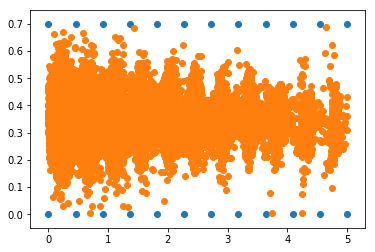

24.815042328002164 sec


In [14]:
my_positions2, my_velocities2, my_processtime2 = simulate2(50000)
plt.figure(1)
plt.scatter(coords_particles[:,0], coords_particles[:,1])
#plt.scatter(coords_negative_particles[:,0], coords_negative_particles[:,1])
plt.scatter(my_positions2[:,0], my_positions2[:,1])
plt.show()
print (my_processtime2,"sec")

## Visulize Conventinal MD

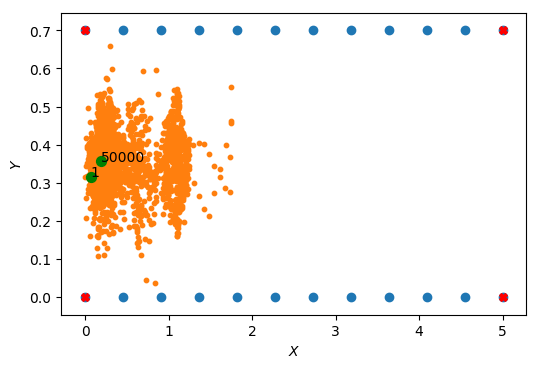

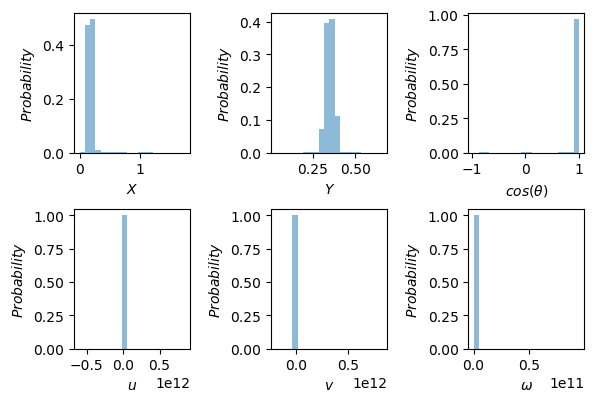

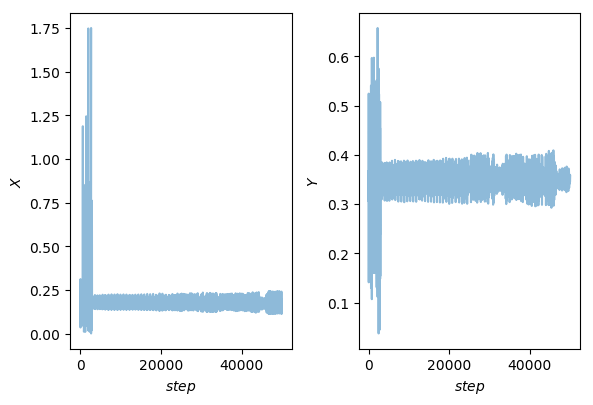

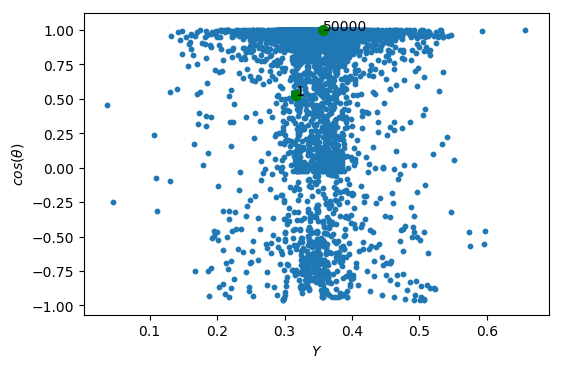

0

In [15]:
visual(coords_negative_particles,coords_particles,my_positions,my_velocities,dpivalue = 100)

## Visulize MD/MC

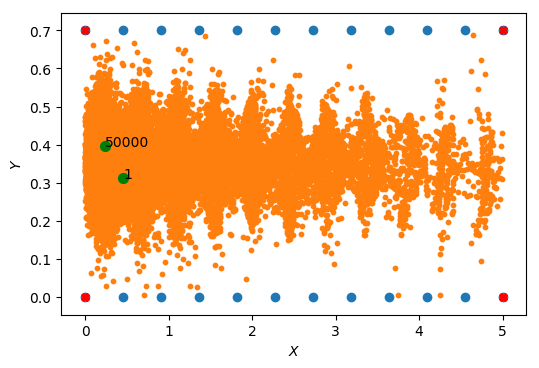

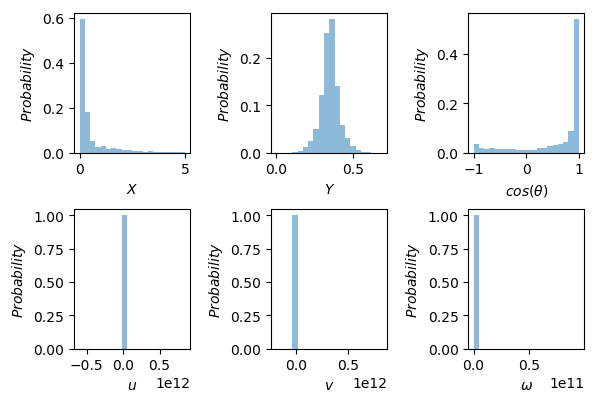

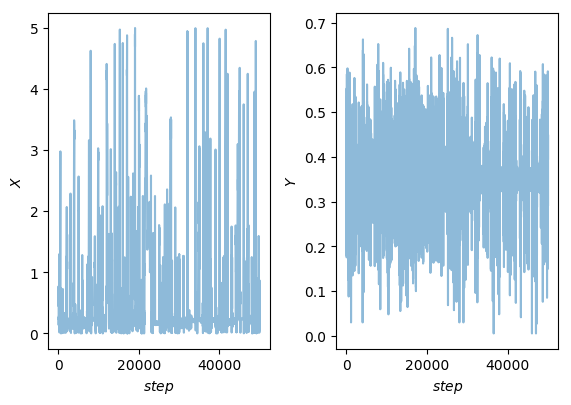

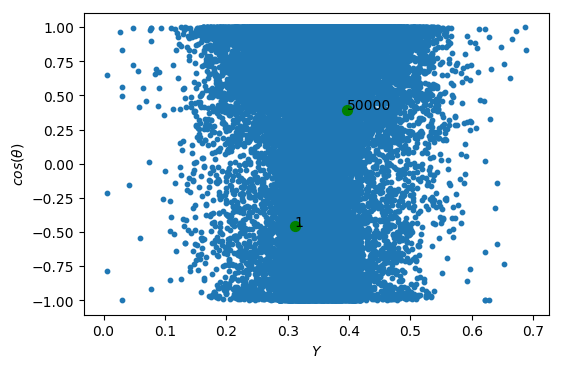

0

In [16]:
visual(coords_negative_particles,coords_particles,my_positions2,my_velocities,dpivalue = 100)